Weight reg + dropout + new of

#### Installs

In [ ]:
#install the stuff to help visualize where we are in training
!pip install wandb
!pip install gcsfs
!pip install pytorch_msssim
!pip install xarray[complete]

#### Imports

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
import xarray as xr
from numpy import float32
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.transforms import CenterCrop

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


#### GPU

In [ ]:
#create device object corresponding to gpu
print(torch.cuda.device_count())
device = torch.device('cuda:0')
print(torch.cuda.get_device_name(0))
torch.cuda.empty_cache()

1
Tesla P100-PCIE-16GB


In [ ]:
#check status and memory of gpu
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t,r,a,f

(17071734784, 0, 0, 0)

In [ ]:
#checks on gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Mar 25 04:10:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#cell of lstm
import torch.nn as nn

class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state=None):
        
        if cur_state is None:
            size = (input_tensor.size()[2], input_tensor.size()[3])
            batch_size = input_tensor.size()[0]
            h_cur, c_cur = self.init_hidden(batch_size, size)
        else:
            h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


In [ ]:
import cv2 as cv
EPS = 1e-7

def inv_sigmoid(x):
    return -torch.log((1-x)/(x+EPS) +EPS) 

def flow_of_batch(batch_x, batch_y, prev):
  #input shape: [batch, img h, img w]
  flows = None
  ma = torch.max(torch.cat((batch_x, batch_y)))
  mi = torch.min(torch.cat((batch_x, batch_y)))
  batch_x =(batch_x - mi) / (ma - mi) * 255 #[batch, img h, img w]
  batch_y =(batch_y - mi) / (ma - mi) * 255
  batch_x = batch_x.squeeze(dim = 1)
  batch_y = batch_y.squeeze(dim = 1)
  new = [0 for _ in range(len(batch_x))]
  for i in range(len(batch_x)):
    x1 = batch_x[i]
    x2 = batch_y[i]
    x1 = x1.detach().cpu().numpy()
    x2 = x2.detach().cpu().numpy()
    new[i] = cv.calcOpticalFlowFarneback(prev=x1,next=x2, flow=prev[i], pyr_scale=0.5, levels=3, winsize=8, iterations=10, poly_n=5, poly_sigma=1.2, flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)
    flow = torch.Tensor(new[i]).to(device)
    if flows is None:
      flows = flow.unsqueeze(dim=0)
    else:
      flows = torch.cat((flows, flow.unsqueeze(dim=0)), dim=0)
  return torch.reshape(flows, (len(batch_x), 2, 128, 128)), new

class ConvLSTMModel(nn.Module):
    def __init__(self, hid_chan, in_chan=1, num_layers=2, use_last = True):
        super(ConvLSTMModel, self).__init__()
        self.num_layers = num_layers
        self.convlstm_layers = nn.ModuleList()
        chans = [in_chan + 2] + [int(hid_chan//2)] + [hid_chan] * num_layers
        for i in range(num_layers):
            cell = ConvLSTMCell(input_dim=chans[i],
                                hidden_dim=chans[i+1],
                                kernel_size=(3, 3),
                                bias=True)
            self.convlstm_layers.append(cell)
        self.input_CNN = nn.Conv2d(in_channels=in_chan + 2,
                                     out_channels=in_chan + 2,
                                     kernel_size=(3, 3),
                                     padding=(1, 1))

        self.decoder_CNN = nn.Conv2d(in_channels=hid_chan + 2,
                                     out_channels=in_chan,
                                     kernel_size=(3, 3),
                                     padding=(1, 1))     
        self.save_fp = "drive/MyDrive/Climate-Hack-2022/Yash/seq2seq/OF+DropoutOnlyLSTM+WD+deep+newOF"
        if use_last:
          self.load_params()
        self = self.to(device)


    def forward(self, inp_imgs, teacher_force=1, teacher_force_start=12):

        """
        Parameters
        ----------
        input_tensor:
            inp_imgs: [batch, num frames, img h, img w]
        output tensor:
            y: [batch, num frames, img h, img w]
        """

        # find size of different input dimensions
        #inp_imgs = inp_imgs.squeeze(dim=0)
        batch_size, frame_cnt, h, w = inp_imgs.size()
        self.frame_cnt = frame_cnt
        inp_imgs = inp_imgs.unsqueeze(dim=2) #[batch, num frames, in chan, img h, img w]

        #setup for optical flow
        flows = torch.zeros((batch_size, 2, h, w)).to(device)
        weight = 1

        outputs = []
        prev = [None for _ in range(batch_size)]
        cur_state = [None for _ in range(self.num_layers)] # [(h0, c0), (h1, c1)...]
        for t in range(self.frame_cnt):
            torch.cuda.empty_cache()
            # generate a mask

            inp = inp_imgs[:, t, :, :, :] # [batch, input channels, img h, img w] # why are we predicitng off a single frame?
            if len(outputs) >= teacher_force_start: #remove eventually #should this be len outputs > 12?
                use_pred = np.random.random([batch_size, 1, 1, 1]) >= teacher_force
                use_pred = torch.Tensor(use_pred)
                use_pred = use_pred.to(device)
                pred_frame = pred[:, -1].unsqueeze(dim=1)
                inp = use_pred * pred_frame + (1 - use_pred) * inp
            inp_img = inp

            #update weighted flow
            if len(outputs) <= 1:
              x1 = inp_imgs[:, 0] # first frame of input #[batch, input channels, img h, img w]
              x2 = inp_imgs[:, 1] # second frame of input
            else:
              x1 = outputs[-1]
              x2 = outputs[-2] #most recent two frames
            flow, prev = flow_of_batch(x1,x2,prev)
            flows = (flows/3 + flow) / weight
            weight += (1/3)**t

            inp = torch.cat((inp, flows), dim = 1)
            inp = self.input_CNN(inp)

            
            for i in range(self.num_layers):
                cur_state[i] = self.convlstm_layers[i](input_tensor=inp, cur_state=cur_state[i])  # we could concat to provide skip conn here
                #add dropout
                inp = nn.Dropout(0.2)(cur_state[i][0])
            final_hid = inp # inp dim: [batch, hid chan, img h, img w]

            encoder_output = torch.cat((final_hid, flows), dim = 1)
            pred = self.decoder_CNN(encoder_output) # [batch, in chan, img h, img w] #change this to take the right dims
            pred = torch.nn.Sigmoid()(inv_sigmoid(inp_img) + pred)
            outputs.append(pred)

        return torch.stack(outputs, dim=1)[:, :, 0, :, :] # [batch, num_frames, img h, img w]

    def ultimate_pred(self, inp_imgs, pred_len=24):
        """
        Parameters
        ----------
        input_tensor:
            inp_imgs: [batch, 12, img h, img w]
        output tensor:
            y: [batch, 24, img h, img w]
        This is the funciton used to make the 12 to 24 final predictions
        """
        batch, inp_len,h,w = inp_imgs.shape
        z = torch.zeros([batch, pred_len - 1, h, w]).to(device)
        aug_inp_img = torch.cat((inp_imgs, z), dim = 1)
        outputs = self(aug_inp_img, teacher_force = 0, teacher_force_start =inp_len)[:, -pred_len:]
        #for i in range(pred_len):
        #    print(i)
        #    out = self(inp_imgs)[:, -1] #[batch, img h, img w]
        #    pred_frame = out.unsqueeze(dim=1) #[batch, 1, img h, img w]
        #    inp_imgs = torch.cat((inp_imgs,pred_frame), dim = 1) #[batch, 12 + i, img h, img w]
        #    outputs.append(out)
        #return torch.stack(outputs, axis=1)
        return outputs
    def load_params(self):
      self.load_state_dict(torch.load(self.save_fp))

    def save_params(self):
      torch.save(self.state_dict(), self.save_fp)

#### Data

In [ ]:
#create dataset and dataloader to run the model on
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
def big_data():
  features = np.load("drive/MyDrive/Climate-Hack-2022/data_preprocessing/batched_data/5184IntsFeaturesB.npz")
  labels = np.load("drive/MyDrive/Climate-Hack-2022/data_preprocessing/batched_data/5184IntsLabelsB.npz")
  sample = (np.random.sample(2400) * 5184).astype(int)
  big_data_f = features["features"][sample]
  big_data_l = labels["labels"][sample]
  mi = min(np.min(big_data_f), np.min(big_data_l), 0)
  ma = max(np.max(big_data_f), np.max(big_data_l),  1023)
  big_data_f =(big_data_f - mi) / (ma - mi)
  big_data_l =(big_data_l - mi) / (ma - mi)
  BATCH_SIZE = 3
  big_loader = TensorDataset(torch.Tensor(big_data_f), torch.Tensor(big_data_l))
  big_loader = DataLoader(big_loader, batch_size=BATCH_SIZE, shuffle = True)
  print(big_data_f.shape, big_data_l.shape)
  return big_loader

In [ ]:
ch_dataloader = big_data()

(2400, 35, 128, 128) (2400, 24, 64, 64)


#### Optional Data visualisation

(torch.Size([3, 35, 128, 128]), torch.Size([3, 24, 64, 64]))

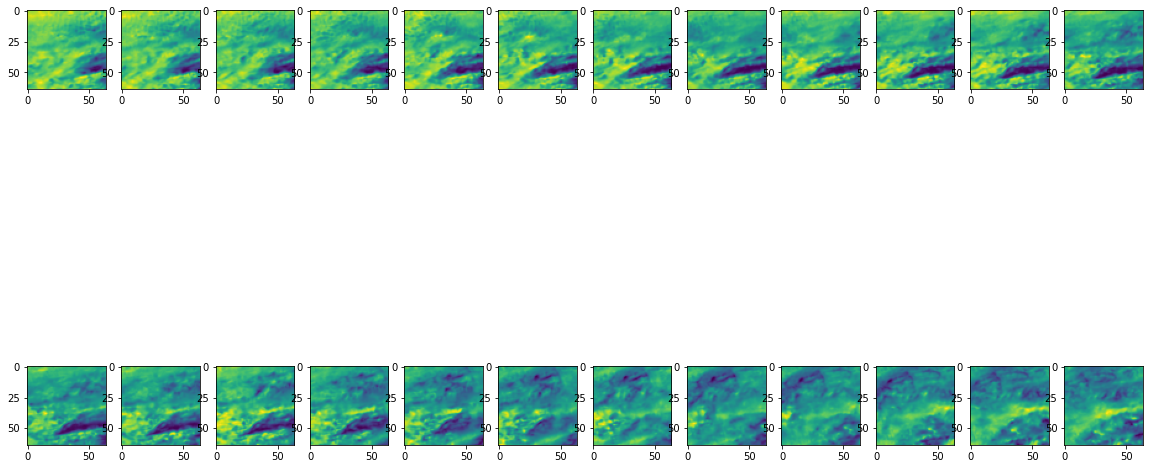

In [ ]:
#basivally this cell j makes sure that the data looks right
for batch, labels in ch_dataloader:
  break
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12)
fig, ax = plt.subplots(ncols = 12, nrows = 2)
for i in range(0, 12):
  ax[0, i].imshow(batch[0,i, 32:96, 32:96])
for i in range(0, 12):
  ax[1, i].imshow(labels[0,i])
batch.shape, labels.shape

#### **Training** Loop

In [ ]:
TF_VAL = 0.1 #0.04186781064218889 #running on this now
model = ConvLSTMModel(24, in_chan=1, num_layers = 10, use_last = True)
#model.load_state_dict(torch.load("drive/MyDrive/Climate-Hack-2022/Yash/seq2seq/OF+DropoutOnlyLSTM+WD+deep"))
!cp drive/MyDrive/Climate-Hack-2022/Yash/loss1023.py .
from loss1023 import MS_SSIMLoss
optimiser = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-5)
criterion =  MS_SSIMLoss(channels=24) #nn.MSELoss()#


In [ ]:
EPOCHS = 20

In [14]:
#this is the training loop
best_val = float("inf")
losses = []
import wandb
wandb.init(project="climate-hacks", entity="liamanthony") #REPLACE WITH YOUR WANDB HERE
for epoch in range(EPOCHS):
  print("Starting epoch ", epoch+1)
  running_loss = 0
  i  = 0
  j = 0
  running_val = 0
  model.train()
  for batch, labels in ch_dataloader:
      # inp: [batch, num frames, img h, img w] label: [batch, num frames, img h, img w]
      batch = batch.to(device)
      labels = labels.to(device) * 1023
      if i>=400:
        if j == 0:
          model.eval()
          with torch.no_grad():
            batch_pred = model.forward(batch, teacher_force=0)
            batch_pred = CenterCrop((64,64))(batch_pred) * 1023
            val_loss = criterion(batch_pred[:,-24:], labels[:,-24:]).cpu().detach()
            log = {"val_loss": val_loss.numpy()}
            running_val += val_loss.item()
            j += 1
        # break
      else:
        optimiser.zero_grad()
        batch_pred = model.forward(batch, teacher_force = TF_VAL)
        batch_pred = CenterCrop((64,64))(batch_pred) * 1023
        batch_loss = criterion(batch_pred[:,-24:], labels[:,-24:])
        batch_loss.backward()

        optimiser.step()
        batch_loss = batch_loss.cpu().detach()
        log = {"batch_loss": batch_loss.numpy()}
        running_loss += batch_loss.item()
        i+=1

      wandb.log(log)

  TF_VAL = TF_VAL * 0.9
  if running_val/j < best_val:
    print("saving model")
    model.save_params()
    # best_val = running_val/j
  losses.append(running_loss/i)
  print("Loss for epoch: ", losses[-1])
  # print("Val loss: ", running_val/j)
  print("TF prob for epoch: ", TF_VAL)

wandb: Currently logged in as: liamanthony (use `wandb login --relogin` to force relogin)


Starting epoch  1
saving model
Loss for epoch:  0.18007231876254082
TF prob for epoch:  0.09000000000000001
Starting epoch  2
saving model
Loss for epoch:  0.18529983043670653
TF prob for epoch:  0.08100000000000002
Starting epoch  3
saving model
Loss for epoch:  0.18857169821858405
TF prob for epoch:  0.07290000000000002
Starting epoch  4
saving model
Loss for epoch:  0.1914241874217987
TF prob for epoch:  0.06561000000000002
Starting epoch  5
saving model
Loss for epoch:  0.18798396438360215
TF prob for epoch:  0.05904900000000002
Starting epoch  6
saving model
Loss for epoch:  0.19789271116256713
TF prob for epoch:  0.05314410000000002
Starting epoch  7
saving model
Loss for epoch:  0.20297303825616836
TF prob for epoch:  0.04782969000000002
Starting epoch  8
saving model
Loss for epoch:  0.20993297830224036
TF prob for epoch:  0.043046721000000024
Starting epoch  9
saving model
Loss for epoch:  0.2082999776303768
TF prob for epoch:  0.03874204890000002
Starting epoch  10
saving mod

In [15]:
torch.max(batch_pred), torch.max(labels)

(tensor(613.7322, device='cuda:0'), tensor(874., device='cuda:0'))

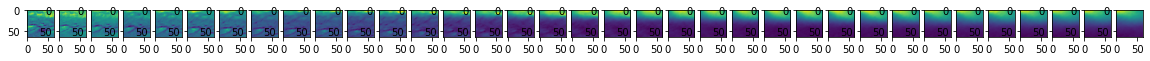

In [16]:
#visualize prediciton so we can make sure it kinda makes sense
plt.rcParams["figure.figsize"] = (20, 12)
pred = batch_pred.cpu().detach().numpy()[0]
fig, ax = plt.subplots(ncols = 35)
for i in range(len(pred)):
  ax[i].imshow(pred[i])

#### Ultimate prediciton visualisation

In [17]:
for batch, labels in ch_dataloader:
  ultimate_input = batch[:,:12]
  y_pred = model.ultimate_pred(ultimate_input.to(device))
  break

In [18]:
y_actual = batch[:,12:]
y_pred_np = y_pred.cpu().detach().numpy()

In [ ]:
plt.rcParams["figure.figsize"] = (20, 12)
fig, ax = plt.subplots(ncols = 12)
for i in range(0, 12):
  ax[i].imshow(ultimate_input[1,i])

In [ ]:
fig, ax = plt.subplots(nrows= 2, ncols = 12)
for i in range(0, 12):
  ax[0][i].imshow(y_actual[1,i])
for i in range(0, 12):
  ax[1][i].imshow(y_pred_np[1,i])

In [ ]:
fig, ax = plt.subplots(nrows= 2, ncols = 12)
for i in range(0, 12):
  ax[0][i].imshow(y_actual[1,i+11])
for i in range(0, 12):
  ax[1][i].imshow(y_pred_np[1,i+11])